In [1]:
import pickle 
import numpy as np
import pandas as pd
import statistics
from PIL import Image
import os 
import random
import time
import matplotlib.pyplot as plt
import netaddr
from ast import literal_eval
import networkx as nx
import joblib
from sklearn.metrics import roc_auc_score
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.ecod import ECOD
from pyod.models.copod import COPOD

In [3]:
#pip install pyod

In [5]:
#pip install netaddr

In [6]:
#run this in cmd to uninstall dgl cpu version
#pip uninstall dgl

In [7]:
#run this in cmd to install dgl gpu version compatible with the cuda version installed, mine is 11.7
#conda install -c dglteam/label/cu117 dgl

In [8]:
print(torch.version.cuda)

11.7


In [9]:
print(torch.__version__)

1.13.0


In [10]:
print(dgl.__version__)

1.1.2+cu117


In [11]:
torch.cuda.is_available()

True

In [13]:
dff = pd.read_csv('Friday_benign_train_70%_all_data/friday_benign_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})

In [14]:
df_train = dff[0:5000]

In [15]:
df_validation = dff[6000:8000]

In [16]:
#dff = dff[0:5000]

In [17]:
df = df_train.copy()

In [18]:
df_b = pd.DataFrame(df['pkt_vals'].values.tolist()).add_prefix('header_byte_')

In [19]:
train_df = pd.concat([df, df_b ], axis =1)

In [20]:
train_df.drop(columns=['stream_number', 'pkt_vals'], inplace = True)

In [21]:
train_df

,src_node,dst_node,header_byte_0,header_byte_1,header_byte_2,header_byte_3,header_byte_4,header_byte_5,header_byte_6,header_byte_7,...,header_byte_390,header_byte_391,header_byte_392,header_byte_393,header_byte_394,header_byte_395,header_byte_396,header_byte_397,header_byte_398,header_byte_399
0,"(3232238105, 50579)","(2899905666, 443)",0.0,0.250980,0.360784,0.176471,0.25098,0.0,0.250980,0.352941,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,"(3232238092, 55312)","(1299738544, 443)",0.0,0.235294,0.000000,0.694118,0.25098,0.0,0.250980,0.698039,...,0.756863,0.152941,0.501961,0.094118,0.000000,0.062745,0.552941,0.854902,0.0,0.0
2,"(2886729729, 60580)","(3232238130, 80)",0.0,0.203922,0.101961,0.290196,0.25098,0.0,0.494118,0.419608,...,0.474510,0.333333,0.313725,0.094118,0.000000,0.898039,0.529412,0.803922,0.0,0.0
3,"(3232238094, 50897)","(1249343076, 443)",0.0,0.203922,0.274510,0.070588,0.25098,0.0,0.501961,0.160784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,"(3232238089, 3423)","(1145287338, 80)",0.0,0.203922,0.478431,0.101961,0.25098,0.0,0.501961,0.749020,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"(3232238095, 56568)","(2899905122, 443)",0.0,0.203922,0.266667,0.701961,0.25098,0.0,0.501961,0.203922,...,0.270588,0.945098,0.313725,0.094118,0.003922,0.341176,0.352941,0.066667,0.0,0.0
4996,"(3232238096, 43762)","(1087539556, 443)",0.0,0.235294,0.117647,0.654902,0.25098,0.0,0.250980,0.529412,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4997,"(3232238097, 59341)","(3627736036, 443)",0.0,0.235294,0.639216,0.411765,0.25098,0.0,0.250980,0.094118,...,0.592157,0.525490,0.501961,0.062745,0.003922,0.329412,0.121569,0.596078,0.0,0.0
4998,"(3232238085, 50092)","(1746125414, 443)",0.0,0.203922,0.262745,0.384314,0.25098,0.0,0.501961,0.760784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [22]:
# Find duplicates based on the first two columns
duplicates = train_df[train_df.duplicated(subset = ['src_node', 'dst_node'], keep=False)]

In [23]:
duplicates

,src_node,dst_node,header_byte_0,header_byte_1,header_byte_2,header_byte_3,header_byte_4,header_byte_5,header_byte_6,header_byte_7,...,header_byte_390,header_byte_391,header_byte_392,header_byte_393,header_byte_394,header_byte_395,header_byte_396,header_byte_397,header_byte_398,header_byte_399
307,"(2886729729, 60632)","(3232238130, 80)",0.0,0.203922,0.105882,0.670588,0.25098,0.0,0.494118,0.415686,...,0.019608,0.141176,0.313725,0.098039,0.0,0.898039,0.509804,0.098039,0.0,0.0
619,"(2886729729, 60834)","(3232238130, 80)",0.0,0.203922,0.133333,0.827451,0.25098,0.0,0.494118,0.388235,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
662,"(2886729729, 59395)","(3232238130, 80)",0.0,0.203922,0.447059,0.835294,0.25098,0.0,0.494118,0.074510,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
678,"(2886729729, 61648)","(3232238130, 80)",0.0,0.203922,0.400000,0.368627,0.25098,0.0,0.494118,0.121569,...,0.513725,0.545098,0.313725,0.062745,0.0,0.898039,0.509804,0.431373,0.0,0.0
706,"(2886729729, 61648)","(3232238130, 80)",0.0,0.203922,0.239216,0.352941,0.25098,0.0,0.494118,0.282353,...,0.450980,0.615686,0.313725,0.062745,0.0,0.898039,0.835294,0.713725,0.0,0.0
741,"(2886729729, 61314)","(3232238130, 80)",0.0,0.203922,0.196078,0.141176,0.25098,0.0,0.494118,0.325490,...,0.760784,0.647059,0.313725,0.094118,0.0,0.898039,0.615686,0.937255,0.0,0.0
876,"(2886729729, 59068)","(3232238130, 80)",0.0,0.203922,0.407843,0.000000,0.25098,0.0,0.494118,0.113725,...,0.180392,0.054902,0.313725,0.062745,0.0,0.898039,0.007843,0.658824,0.0,0.0
1082,"(2886729729, 59041)","(3232238130, 80)",0.0,0.203922,0.403922,0.317647,0.25098,0.0,0.494118,0.117647,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
1347,"(2886729729, 59916)","(3232238130, 80)",0.0,0.203922,0.015686,0.101961,0.25098,0.0,0.494118,0.505882,...,0.690196,0.047059,0.313725,0.098039,0.0,0.898039,0.509804,0.098039,0.0,0.0
1559,"(2886729729, 57991)","(3232238130, 80)",0.0,0.203922,0.266667,0.556863,0.25098,0.0,0.494118,0.254902,...,0.066667,0.266667,0.313725,0.066667,0.0,0.898039,0.156863,0.337255,0.0,0.0


In [24]:
# Graph Creation
def create_graph_from_df(df):
    
    duplicates = df[df.duplicated(subset = ['src_node', 'dst_node'], keep=False)]
    
    # Create a set of unique tuples for 'Column1'
    unique_values = set(df['src_node'])

    # Generate unique random tuples for duplicates
    for index, row in duplicates.iterrows():
        while True:
            
            random_tuple = (random.randint(2886729729, 3232238097), random.randint(43453, 57705))  
            if random_tuple not in unique_values:
                unique_values.add(random_tuple)
                df.at[index, 'src_node'] = random_tuple
                break
    


    # Create a mapping from unique node tuples to node IDs
    nodes = list(set(df['src_node'].tolist() + df['dst_node'].tolist()))

    
    node_to_id = {node: i for i, node in enumerate(nodes)}

    # Create source and destination tensors using the mapping
    src = torch.tensor([node_to_id[node] for node in df['src_node']])
    dst = torch.tensor([node_to_id[node] for node in df['dst_node']])

    # Create the DGL graph
    graph = dgl.graph((src, dst))

    
    # Ensure that the graph has correct edge_ids
    src, dst = graph.edges()

    # Create the DGL graph as an undirected graph
    u_graph = dgl.graph((torch.cat([src, dst]), torch.cat([dst, src])))


    # Add edge features to the graph
    edge_features = torch.tensor(df.iloc[:, 2:].values, dtype=torch.float32)

    edge_features = torch.cat([edge_features, edge_features], dim=0)

    
    u_graph.edata['features'] = edge_features
    
    print(u_graph)
    
    u_graph = u_graph.to("cuda")

    return u_graph

In [25]:
train_graph = create_graph_from_df(train_df)

Graph(num_nodes=7120, num_edges=10000,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})


In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_heads, use_bias):
        super().__init__()
        
        self.out_dim = out_dim
        self.num_heads = num_heads
        
        if use_bias:
            self.Q = nn.Linear(in_dim, out_dim * num_heads, bias=True)
            self.K = nn.Linear(in_dim, out_dim * num_heads, bias=True)
            self.V = nn.Linear(in_dim, out_dim * num_heads, bias=True)
            self.proj_e = nn.Linear(in_dim, out_dim * num_heads, bias=True)
        else:
            self.Q = nn.Linear(in_dim, out_dim * num_heads, bias=False)
            self.K = nn.Linear(in_dim, out_dim * num_heads, bias=False)
            self.V = nn.Linear(in_dim, out_dim * num_heads, bias=False)
            self.proj_e = nn.Linear(in_dim, out_dim * num_heads, bias=False)
    
    def propagate_attention(self, g):
        # Compute attention score
        g.apply_edges(src_dot_dst('K_h', 'Q_h', 'score')) #, edges)
        
        # scaling
        g.apply_edges(scaling('score', np.sqrt(self.out_dim)))
        
        # Use available edge features to modify the scores
        g.apply_edges(imp_exp_attn('score', 'proj_e'))
        
        # Copy edge features as e_out to be passed to FFN_e
        g.apply_edges(out_edge_features('score'))
        
        # softmax
        g.apply_edges(exp('score'))

        # Send weighted values to target nodes
        eids = g.edges()
        g.send_and_recv(eids, fn.src_mul_edge('V_h', 'score', 'V_h'), fn.sum('V_h', 'wV'))
        g.send_and_recv(eids, fn.copy_edge('score', 'score'), fn.sum('score', 'z'))
    
    def forward(self, g, h, e):
        
        Q_h = self.Q(h)
        K_h = self.K(h)
        V_h = self.V(h)
        proj_e = self.proj_e(e)
        
        # Reshaping into [num_nodes, num_heads, feat_dim] to 
        # get projections for multi-head attention
        g.ndata['Q_h'] = Q_h.view(-1, self.num_heads, self.out_dim)
        g.ndata['K_h'] = K_h.view(-1, self.num_heads, self.out_dim)
        g.ndata['V_h'] = V_h.view(-1, self.num_heads, self.out_dim)
        g.edata['proj_e'] = proj_e.view(-1, self.num_heads, self.out_dim)
        
        self.propagate_attention(g)
        
        h_out = g.ndata['wV'] / (g.ndata['z'] + torch.full_like(g.ndata['z'], 1e-6)) # adding eps to all values here
        e_out = g.edata['e_out']
        
        return h_out, e_out

In [ ]:
class GraphTransformerLayer(nn.Module):
    """
        Param: 
    """
    def __init__(self, in_dim, out_dim, num_heads, dropout=0.0, layer_norm=False, batch_norm=True, residual=True, use_bias=False):
        super().__init__()

        self.in_channels = in_dim
        self.out_channels = out_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.residual = residual
        self.layer_norm = layer_norm     
        self.batch_norm = batch_norm
        
        self.attention = MultiHeadAttentionLayer(in_dim, out_dim//num_heads, num_heads, use_bias)
        
        self.O_h = nn.Linear(out_dim, out_dim)
        self.O_e = nn.Linear(out_dim, out_dim)

        if self.layer_norm:
            self.layer_norm1_h = nn.LayerNorm(out_dim)
            self.layer_norm1_e = nn.LayerNorm(out_dim)
            
        if self.batch_norm:
            self.batch_norm1_h = nn.BatchNorm1d(out_dim)
            self.batch_norm1_e = nn.BatchNorm1d(out_dim)
        
        # FFN for h
        self.FFN_h_layer1 = nn.Linear(out_dim, out_dim*2)
        self.FFN_h_layer2 = nn.Linear(out_dim*2, out_dim)
        
        # FFN for e
        self.FFN_e_layer1 = nn.Linear(out_dim, out_dim*2)
        self.FFN_e_layer2 = nn.Linear(out_dim*2, out_dim)

        if self.layer_norm:
            self.layer_norm2_h = nn.LayerNorm(out_dim)
            self.layer_norm2_e = nn.LayerNorm(out_dim)
            
        if self.batch_norm:
            self.batch_norm2_h = nn.BatchNorm1d(out_dim)
            self.batch_norm2_e = nn.BatchNorm1d(out_dim)
        
    def forward(self, g, h, e):
        h_in1 = h # for first residual connection
        e_in1 = e # for first residual connection
        
        # multi-head attention out
        h_attn_out, e_attn_out = self.attention(g, h, e)
        
        h = h_attn_out.view(-1, self.out_channels)
        e = e_attn_out.view(-1, self.out_channels)
        
        h = F.dropout(h, self.dropout, training=self.training)
        e = F.dropout(e, self.dropout, training=self.training)

        h = self.O_h(h)
        e = self.O_e(e)

        if self.residual:
            h = h_in1 + h # residual connection
            e = e_in1 + e # residual connection

        if self.layer_norm:
            h = self.layer_norm1_h(h)
            e = self.layer_norm1_e(e)

        if self.batch_norm:
            h = self.batch_norm1_h(h)
            e = self.batch_norm1_e(e)

        h_in2 = h # for second residual connection
        e_in2 = e # for second residual connection

        # FFN for h
        h = self.FFN_h_layer1(h)
        h = F.relu(h)
        h = F.dropout(h, self.dropout, training=self.training)
        h = self.FFN_h_layer2(h)

        # FFN for e
        e = self.FFN_e_layer1(e)
        e = F.relu(e)
        e = F.dropout(e, self.dropout, training=self.training)
        e = self.FFN_e_layer2(e)

        if self.residual:
            h = h_in2 + h # residual connection       
            e = e_in2 + e # residual connection  

        if self.layer_norm:
            h = self.layer_norm2_h(h)
            e = self.layer_norm2_e(e)

        if self.batch_norm:
            h = self.batch_norm2_h(h)
            e = self.batch_norm2_e(e)             

        return h, e
        
    def __repr__(self):
        return '{}(in_channels={}, out_channels={}, heads={}, residual={})'.format(self.__class__.__name__,
                                             self.in_channels,
                                             self.out_channels, self.num_heads, self.residual)

In [42]:
class GraphAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(GraphAutoencoder, self).__init__()
        
        # Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.GraphTransformerLayer(
                d_model=input_dim,
                nhead=num_heads,  # Number of self-attention heads
                dim_feedforward=hidden_dim,
                activation='relu'
            ),
            num_layers=num_layers
        )
        
        # Graph Decoder
        self.decoder = nn.Linear(input_dim, input_dim)

    def forward(self, g, features):
        # Apply Transformer Encoder to edge features
        edge_features = self.transformer_encoder(features)
        
        # Decode the transformed edge features
        decoded_features = self.decoder(features)
        
        return decoded_features

In [43]:
# Set hyperparameters
input_dim = 400  # Number of edge features
hidden_dim = 64  # Dimension of the latent space
num_heads = 8  # Number of attention heads in the transformer
learning_rate = 0.001
epochs = 100
num_layers = 2

batch_size = 5000

In [44]:
class CustomGraphDataset(torch.utils.data.Dataset):
    def __init__(self, graph, features):
        self.graph = graph
        self.features = features

    def __len__(self):
        return 1  # Since you have only one graph

    def __getitem__(self, idx):
        return self.graph, self.features

In [45]:
df_validation  = df_validation.reset_index(drop=True)

In [46]:
df_p_val = pd.DataFrame(df_validation ['pkt_vals'].values.tolist()).add_prefix('header_byte_')
val_df = pd.concat([df_validation , df_p_val ], axis =1)
val_df.drop(columns=[ 'stream_number', 'pkt_vals'], inplace = True)
val_graph = create_graph_from_df(val_df)

Graph(num_nodes=3106, num_edges=4000,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})


In [47]:
custom_dataset_train = CustomGraphDataset(train_graph, train_graph.edata['features'])

In [48]:
custom_dataset_val = CustomGraphDataset(val_graph, train_graph.edata['features'])

In [49]:
# Define the collate function to handle a list of batched graphs
def collate(samples):
    batched_graphs, features = zip(*samples)
    batched_graph = dgl.batch(batched_graphs)
    return batched_graph, torch.stack(features)

In [50]:
data_loader_train = DataLoader(custom_dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate)

In [51]:
data_loader_val = DataLoader(custom_dataset_val, batch_size=batch_size, shuffle=True, collate_fn=collate)

In [52]:
# Create and train the autoencoder
autoencoder = GraphAutoencoder(input_dim, hidden_dim, num_heads)
autoencoder = autoencoder.to("cuda")

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [53]:
# Define a function for validation
def validate_autoencoder(model, data_loader_val):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batched_graph, batched_features in data_loader_val:
            output = model(batched_graph, batched_features)
            loss = criterion(output, batched_features)
            total_loss += loss.item()
    
    average_loss = total_loss / len(data_loader_val)
    return average_loss

In [54]:
def train_autoencoder(model, data_loader_train, epochs, learning_rate):
    model.train()
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state_dict = None
    scaler = GradScaler() 
    
    for epoch in range(epochs):
        total_loss = 0
        
        for batched_graph, batched_features in data_loader_train:
            optimizer.zero_grad()
            
            with autocast():  # Automatic mixed precision
                output = model(batched_graph, batched_features)
                loss = criterion(output, batched_features)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
        
        average_loss = total_loss / len(data_loader_train)
        train_losses.append(average_loss)
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {average_loss:.4f}')
        
        # Validation
        val_loss = validate_autoencoder(model, data_loader_val)
        val_losses.append(val_loss)
        print(f'Epoch [{epoch + 1}/{epochs}], Validation Loss: {val_loss:.4f}')
        
        print('-' * 20)

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()

    # Plot both training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    # Save the best model's state_dict to a file
    torch.save(best_model_state_dict, 'best_GTAE_model_8pkt.pth')

Epoch [1/100], Train Loss: 0.1466
Epoch [1/100], Validation Loss: 0.1179
--------------------
Epoch [2/100], Train Loss: 0.1179
Epoch [2/100], Validation Loss: 0.0967
--------------------
Epoch [3/100], Train Loss: 0.0967
Epoch [3/100], Validation Loss: 0.0814
--------------------
Epoch [4/100], Train Loss: 0.0814
Epoch [4/100], Validation Loss: 0.0704
--------------------
Epoch [5/100], Train Loss: 0.0704
Epoch [5/100], Validation Loss: 0.0627
--------------------
Epoch [6/100], Train Loss: 0.0627
Epoch [6/100], Validation Loss: 0.0573
--------------------
Epoch [7/100], Train Loss: 0.0573
Epoch [7/100], Validation Loss: 0.0536
--------------------
Epoch [8/100], Train Loss: 0.0536
Epoch [8/100], Validation Loss: 0.0511
--------------------
Epoch [9/100], Train Loss: 0.0511
Epoch [9/100], Validation Loss: 0.0494
--------------------
Epoch [10/100], Train Loss: 0.0494
Epoch [10/100], Validation Loss: 0.0481
--------------------
Epoch [11/100], Train Loss: 0.0481
Epoch [11/100], Validat

Epoch [87/100], Train Loss: 0.0189
Epoch [87/100], Validation Loss: 0.0188
--------------------
Epoch [88/100], Train Loss: 0.0188
Epoch [88/100], Validation Loss: 0.0187
--------------------
Epoch [89/100], Train Loss: 0.0187
Epoch [89/100], Validation Loss: 0.0185
--------------------
Epoch [90/100], Train Loss: 0.0185
Epoch [90/100], Validation Loss: 0.0184
--------------------
Epoch [91/100], Train Loss: 0.0184
Epoch [91/100], Validation Loss: 0.0183
--------------------
Epoch [92/100], Train Loss: 0.0183
Epoch [92/100], Validation Loss: 0.0182
--------------------
Epoch [93/100], Train Loss: 0.0182
Epoch [93/100], Validation Loss: 0.0181
--------------------
Epoch [94/100], Train Loss: 0.0181
Epoch [94/100], Validation Loss: 0.0179
--------------------
Epoch [95/100], Train Loss: 0.0179
Epoch [95/100], Validation Loss: 0.0178
--------------------
Epoch [96/100], Train Loss: 0.0178
Epoch [96/100], Validation Loss: 0.0177
--------------------
Epoch [97/100], Train Loss: 0.0177
Epoch

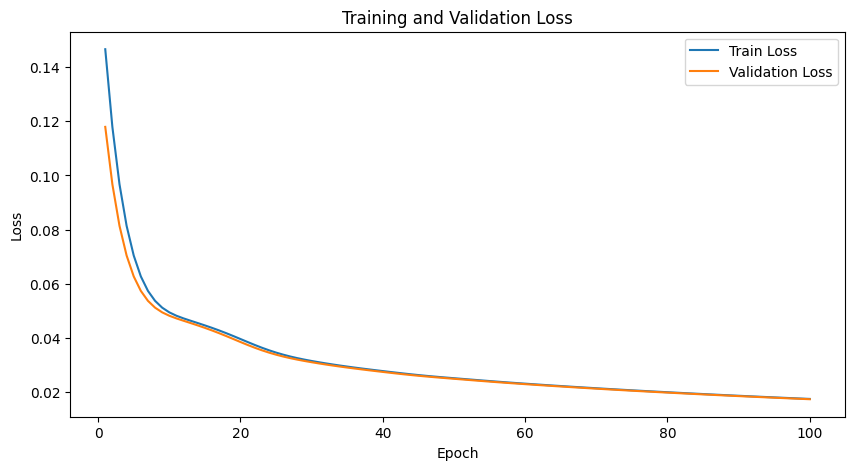

In [55]:
train_autoencoder(autoencoder, data_loader_train, epochs, learning_rate)

In [39]:
#save_model(autoencoder, optimizer, epochs, losses[-1], 'graph_autoencoder_model_2pkt.h5')

In [40]:
#autoencoder = torch.load('graph_autoencoder_model_2pkt.h5')

In [41]:
df_port = pd.read_csv('Friday_portscan_all/friday_portscan_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
#df_bot = pd.read_csv('Friday_botnet_all/friday_botnet_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_ddos = pd.read_csv('Friday_ddos_all/friday_ddos_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_ddos = df_ddos[0:5000]



df_infiltration = pd.read_csv('Thursday_infiltration_all/thursday_infiltration_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_bruteforce = pd.read_csv('Thursday_web_bruteforce_all/thursday_bruteforce_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
#df_xss = pd.read_csv('Thursday_web_xss_all/thursday_xss_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})


df_ssh = pd.read_csv('Tuesday_ssh_all/tuesday_ssh_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_ftp = pd.read_csv('Tuesday_ftp_all/tuesday_ftp_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})


df_goldeneye = pd.read_csv('Wednesday_goldeneye_all/wednesday_goldeneye_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_heartbleed = pd.read_csv('Wednesday_heartbleed_all/wednesday_heartbleed_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_slowhttp = pd.read_csv('Wednesday_slowlhttptest_all/wednesday_slowlhttptest_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_slowloris = pd.read_csv('Wednesday_slowloris_all/wednesday_slowloris_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_hulk = pd.read_csv('Wednesday_hulk_all/wednesday_hulk_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_hulk =df_hulk[0:5000]

In [42]:
df_test_benign = pd.read_csv('Friday_benign_test_30%_all_data/friday_benign_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_test_benign = df_test_benign[0:5000]

In [43]:
#autoencoder = GraphAutoencoder(input_dim, hidden_dim, num_heads)

In [44]:
#autoencoder.load_state_dict(torch.load('best_GTAE_model_6pkt.pth'))   #autoencoder.to("cpu")

In [45]:
train_graph = train_graph.to("cpu")

In [46]:
autoencoder = autoencoder.to("cpu")

In [47]:
train_benign_encoded = autoencoder(train_graph, train_graph.edata['features']).detach().numpy()

In [48]:
scaler = StandardScaler()
train_benign_encoded = scaler.fit_transform(train_benign_encoded)

In [56]:
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.ecod import ECOD
from pyod.models.copod import COPOD

In [57]:
from pyod.models.ocsvm import OCSVM
from pyod.models.iforest import IForest
from pyod.models.inne import INNE
from pyod.models.lscp import LSCP
from pyod.models.deep_svdd import DeepSVDD

In [58]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [59]:
model_ocsvm = OCSVM(nu=0.05, contamination=0.06)  # contamination is the expected proportion of outliers
model_ocsvm.fit(train_benign_encoded)

OCSVM(cache_size=200, coef0=0.0, contamination=0.06, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.05, shrinking=True, tol=0.001,
   verbose=False)

In [60]:
model_iforest = IForest(contamination=0.09)  
model_iforest.fit(train_benign_encoded)

IForest(behaviour='old', bootstrap=False, contamination=0.09,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [61]:
model_inne = INNE(contamination=0.09)
model_inne.fit(train_benign_encoded)

INNE(contamination=0.09, max_samples='auto', n_estimators=200,
   random_state=None)

In [66]:
model_cblof = CBLOF(contamination=0.09) 
model_cblof.fit(train_benign_encoded)

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.09, n_clusters=8, n_jobs=None, random_state=None,
   use_weights=False)

In [67]:
model_hbos = HBOS(contamination=0.09)  
model_hbos.fit(train_benign_encoded)

HBOS(alpha=0.1, contamination=0.09, n_bins=10, tol=0.5)

In [136]:
df_test_lst = [( 'Benign', df_test_benign), ('DoS GoldenEye', df_goldeneye), ('Heartbleed', df_heartbleed), 
               ('DoS Slowhttptest', df_slowhttp), ('DoS Slowloris', df_slowloris),
               ('DoS Hulk', df_hulk),  ('PortScan',df_port), ('DDoS', df_ddos), 
               ('Infiltration', df_infiltration), ('Web Attack-BruteForce', df_bruteforce),
               ('SSH-Patator', df_ssh), ('FTP-Patator', df_ftp)]

data = []
test_encoded_2017 = {}

for i in(range(len(df_test_lst))):
    
    attack_name = df_test_lst[i][0]
    
    df = df_test_lst[i][1]
    
    df_p = pd.DataFrame(df['pkt_vals'].values.tolist()).add_prefix('header_byte_')
    test_df = pd.concat([df, df_p ], axis =1)
    test_df.drop(columns=[ 'stream_number', 'pkt_vals'], inplace = True)
    test_graph = create_graph_from_df(test_df)
    
    num_nodes = test_graph.number_of_nodes()
    num_edges = test_graph.number_of_edges()

    test_graph = test_graph.to("cpu")
    test_encoded = autoencoder(test_graph, test_graph.edata['features']).detach().numpy()
    test_encoded = scaler.transform(test_encoded)
    
    test_encoded_2017[f'{attack_name}'] = test_encoded
    
#     #svm
#     anomalies_svm = model_svm.predict(test_encoded)
#     count_svm = np.count_nonzero(anomalies_svm == -1)
#     num_anomaly_svm = count_svm/2

#     #if
#     anomalies_if = model_if.predict(test_encoded)
#     count_if = np.count_nonzero(anomalies_if == -1)
#     num_anomaly_if = count_if/2
    
    #ocsvm
    anomalies_ocsvm = model_ocsvm.predict(test_encoded)
    count_ocsvm = np.count_nonzero(anomalies_ocsvm == 1)
    num_anomaly_ocsvm = count_ocsvm/2
    
    #iforest
    anomalies_iforest = model_iforest.predict(test_encoded)
    count_iforest = np.count_nonzero(anomalies_iforest == 1)
    num_anomaly_iforest = count_iforest/2
    
    
#     #cblof
#     anomalies_cblof = model_cblof.predict(test_encoded)
#     count_cblof = np.count_nonzero(anomalies_cblof == 1)
#     num_anomaly_cblof = count_cblof/2
    
    #hbos
    anomalies_hbos = model_hbos.predict(test_encoded)
    count_hbos = np.count_nonzero(anomalies_hbos == 1)
    num_anomaly_hbos = count_hbos/2
    
    
    #inne
    anomalies_inne = model_inne.predict(test_encoded)
    count_inne = np.count_nonzero(anomalies_inne == 1)
    num_anomaly_inne = count_inne/2
    
    
#     #svdd
#     anomalies_svdd = model_svdd.predict(test_encoded)
#     count_svdd = np.count_nonzero(anomalies_svdd == 1)
#     num_anomaly_svdd = count_svdd/2
    
    
    #ensemble method: Voting-based Ensembles (majority vorting)  Combines results from multiple algorithms to make a final decision on anomalies.
    combined_predictions = [anomalies_ocsvm, anomalies_iforest, anomalies_hbos, anomalies_inne ]

    # Use np.sum(axis=0) to count the number of "-1" predictions (anomalies) for each sample
    votes = np.sum([prediction == 1 for prediction in combined_predictions], axis=0)
    anomalies_ensemble = (votes >= 1).astype(int)
    
    count_ensemble = np.count_nonzero(anomalies_ensemble == 1)
    num_anomaly_ensemble = count_ensemble/2
    
    #create df of results
    data.append([attack_name, int(num_nodes), int(num_edges/2), 
                  round((num_anomaly_ocsvm/int(num_edges/2))*100, 2),
                  round((num_anomaly_iforest/int(num_edges/2))*100, 2),
                  round((num_anomaly_hbos/int(num_edges/2))*100, 2),
                  round((num_anomaly_inne/int(num_edges/2))*100, 2),
                  round((num_anomaly_ensemble/int(num_edges/2))*100, 2)])

df_2017_anomaly = pd.DataFrame(data, columns= ['Class', 'Number of nodes', 'Number of edges (flows)',  
                                             'Anomaly Detection Rate (OCSVM)',
                                             'Anomaly Detection Rate (IForest)',
                                             'Anomaly Detection Rate (HBOS)',
                                             'Anomaly Detection Rate (INNE)',
                                             'Anomaly Detection Rate (Ensemble)'])

Graph(num_nodes=7100, num_edges=10000,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})
Graph(num_nodes=6235, num_edges=12180,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})
Graph(num_nodes=2032, num_edges=2936,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})
Graph(num_nodes=1248, num_edges=1928,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})
Graph(num_nodes=1294, num_edges=2004,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})
Graph(num_nodes=5382, num_edges=10000,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})
Graph(num_nodes=8242, num_edges=12902,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})
Graph(num_nodes=6072, num_edge

In [103]:
df_2017_anomaly

,Class,Number of nodes,Number of edges (flows),Anomaly Detection Rate (OCSVM),Anomaly Detection Rate (IForest),Anomaly Detection Rate (HBOS),Anomaly Detection Rate (INNE),Anomaly Detection Rate (Ensemble)
0,Benign,7100,5000,8.06,9.86,9.92,9.98,13.12
1,DoS GoldenEye,6235,6090,98.49,96.86,97.57,96.45,99.08
2,Heartbleed,2032,1468,99.32,97.21,98.23,96.59,99.52
3,DoS Slowhttptest,1248,964,99.59,98.34,99.17,98.55,99.79
4,DoS Slowloris,1294,1002,99.20,97.80,98.60,97.21,99.60
5,DoS Hulk,5382,5000,98.02,96.26,97.18,96.24,98.74
6,PortScan,8242,6451,97.75,95.27,96.96,95.75,98.50
7,DDoS,6072,5000,98.74,97.30,98.42,96.66,99.34
8,Infiltration,2437,1764,99.66,98.36,98.81,97.73,99.83
9,Web Attack-BruteForce,189,140,98.57,98.57,99.29,95.71,99.29


In [104]:
df_2017_anomaly.to_csv('Final_Results_8pkt_Anomaly_Detection_2017.csv')

In [105]:
df_test_benign_2018 = pd.read_csv('2018_benign_test/thursday_benign_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})

df_ddos_2018 = pd.read_csv('2018_ddos/2018_ddos_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})




df_infiltration_2018 = pd.read_csv('2018_infiltration/2018_infiltration_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_bruteforce_2018 = pd.read_csv('2018_wa_bruteforce/2018_wa_bruteforce_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_xss_2018 = pd.read_csv('2018_wa_xss/2018_wa_xss_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_sql_2018 = pd.read_csv('2018_wa_sql/2018_wa_sql_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})

df_ssh_2018 = pd.read_csv('2018_ssh_patator/2018_ssh_patator_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_ftp_2018 = pd.read_csv('2018_ftp_patator/2018_ftp_patator_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})


df_goldeneye_2018 = pd.read_csv('2018_dos_goldeneye/2018_dos_goldeneye_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_slowhttp_2018 = pd.read_csv('2018_dos_slowhttptest/2018_dos_slowhttptest_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_slowloris_2018 = pd.read_csv('2018_dos_slowloris/2018_dos_slowloris_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})
df_hulk_2018 = pd.read_csv('2018_dos_hulk/2018_dos_hulk_8pkt.csv', converters={'pkt_vals': literal_eval, 'stream_number':literal_eval , 'dst_node':literal_eval , 'src_node':literal_eval})


In [106]:
df_test_lst = [('Benign', df_test_benign_2018), ('DoS GoldenEye', df_goldeneye_2018),  
                ('DoS Slowloris', df_slowloris_2018),
              ('DDoS', df_ddos_2018), 
               ('Infiltration', df_infiltration_2018), ('Web Attack-BruteForce', df_bruteforce_2018),
               ('Web Attack XSS', df_xss_2018),  ('SSH-Patator', df_ssh_2018), ('FTP-Patator', df_ftp_2018)]

data = []
test_encoded_2018 = {}
for i in(range(len(df_test_lst))):
    
    attack_name = df_test_lst[i][0]
    
    df = df_test_lst[i][1]
    
    df_p = pd.DataFrame(df['pkt_vals'].values.tolist()).add_prefix('header_byte_')
    test_df = pd.concat([df, df_p ], axis =1)
    test_df.drop(columns=[ 'stream_number', 'pkt_vals'], inplace = True)
    test_graph = create_graph_from_df(test_df)
    
    num_nodes = test_graph.number_of_nodes()
    num_edges = test_graph.number_of_edges()

    test_graph = test_graph.to("cpu")
    test_encoded = autoencoder(test_graph, test_graph.edata['features']).detach().numpy()
    test_encoded = scaler.transform(test_encoded)
    
    test_encoded_2018[f'{attack_name}'] = test_encoded
    
    #ocsvm
    anomalies_ocsvm = model_ocsvm.predict(test_encoded)
    count_ocsvm = np.count_nonzero(anomalies_ocsvm == 1)
    num_anomaly_ocsvm = count_ocsvm/2
    
    #iforest
    anomalies_iforest = model_iforest.predict(test_encoded)
    count_iforest = np.count_nonzero(anomalies_iforest == 1)
    num_anomaly_iforest = count_iforest/2
    
    
    #hbos
    anomalies_hbos = model_hbos.predict(test_encoded)
    count_hbos = np.count_nonzero(anomalies_hbos == 1)
    num_anomaly_hbos = count_hbos/2
    
    
    #inne
    anomalies_inne = model_inne.predict(test_encoded)
    count_inne = np.count_nonzero(anomalies_inne == 1)
    num_anomaly_inne = count_inne/2
    

    
    #ensemble method: Voting-based Ensembles (majority vorting)  Combines results from multiple algorithms to make a final decision on anomalies.
    combined_predictions = [anomalies_ocsvm, anomalies_iforest, anomalies_hbos, anomalies_inne ]

    # Use np.sum(axis=0) to count the number of "-1" predictions (anomalies) for each sample
    votes = np.sum([prediction == 1 for prediction in combined_predictions], axis=0)
    anomalies_ensemble = (votes >= 1).astype(int)
    
    count_ensemble = np.count_nonzero(anomalies_ensemble == 1)
    num_anomaly_ensemble = count_ensemble/2
    
    #create df of results
    data.append([attack_name, int(num_nodes), int(num_edges/2), 
                  round((num_anomaly_ocsvm/int(num_edges/2))*100, 2),
                  round((num_anomaly_iforest/int(num_edges/2))*100, 2),
                  round((num_anomaly_hbos/int(num_edges/2))*100, 2),
                  round((num_anomaly_inne/int(num_edges/2))*100, 2),
                  round((num_anomaly_ensemble/int(num_edges/2))*100, 2)])

df_2018_anomaly = pd.DataFrame(data, columns= ['Class', 'Number of nodes', 'Number of edges (flows)',  
                                             'Anomaly Detection Rate (OCSVM)',
                                             'Anomaly Detection Rate (IForest)',
                                             'Anomaly Detection Rate (HBOS)',
                                             'Anomaly Detection Rate (INNE)',
                                             'Anomaly Detection Rate (Ensemble)'])

Graph(num_nodes=2056, num_edges=3516,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})
Graph(num_nodes=1879, num_edges=3754,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})
Graph(num_nodes=940, num_edges=1876,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})
Graph(num_nodes=2001, num_edges=4000,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})
Graph(num_nodes=57, num_edges=72,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})
Graph(num_nodes=317, num_edges=560,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})
Graph(num_nodes=201, num_edges=330,
      ndata_schemes={}
      edata_schemes={'features': Scheme(shape=(400,), dtype=torch.float32)})
Graph(num_nodes=676, num_edges=1346,
      

In [107]:
df_2018_anomaly

,Class,Number of nodes,Number of edges (flows),Anomaly Detection Rate (OCSVM),Anomaly Detection Rate (IForest),Anomaly Detection Rate (HBOS),Anomaly Detection Rate (INNE),Anomaly Detection Rate (Ensemble)
0,Benign,2056,1758,97.72,91.35,92.72,95.90,98.18
1,DoS GoldenEye,1879,1877,96.80,94.99,96.00,93.98,97.50
2,DoS Slowloris,940,938,98.83,98.19,99.04,92.96,99.47
3,DDoS,2001,2000,11.15,0.00,0.00,3.90,12.00
4,Infiltration,57,36,100.00,100.00,100.00,97.22,100.00
5,Web Attack-BruteForce,317,280,100.00,97.14,100.00,91.79,100.00
6,Web Attack XSS,201,165,98.79,95.76,96.97,93.33,99.39
7,SSH-Patator,676,673,96.29,94.06,95.84,93.46,98.51
8,FTP-Patator,45,43,100.00,100.00,100.00,100.00,100.00


In [108]:
df_2018_anomaly.to_csv('Final_Results_8pkt_Anomaly_Detection_2018.csv')

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [138]:
# Create a new dictionary with labels
test_encoded_2017_binary = {}

# Assign the first item (df1) as the "normal" class
test_encoded_2017_binary['Benign'] = test_encoded_2017['Benign']

# Assign the remaining items (df2 to df_last) as the "malicious" class
for df_name, data in test_encoded_2017.items():
    if df_name != 'Benign':
        test_encoded_2017_binary['Malicious'] = data

In [139]:
test_encoded_2017_binary

{'Benign': array([[ 1.3842349 , -0.25775224, -0.680054  , ...,  0.88096184,
          0.73173064, -0.3637421 ],
        [ 0.35697272,  0.17681848, -0.58993465, ...,  0.57071203,
         -2.3771684 ,  0.84124535],
        [ 0.78178036, -1.3120806 , -0.4212792 , ..., -0.9960443 ,
         -0.4589124 ,  0.9064637 ],
        ...,
        [-0.8168102 ,  1.1108022 , -0.19076559, ..., -0.7653844 ,
         -0.65637565, -0.8842164 ],
        [-0.49184668, -0.37248865, -1.5944183 , ..., -0.98081934,
          1.4844657 , -0.8094278 ],
        [-0.5070298 , -1.2268152 , -0.30030003, ..., -0.9367719 ,
          0.13778332, -0.06472817]], dtype=float32),
 'Malicious': array([[-2.1528397 , -1.4033673 , -0.36259583, ..., -1.1398325 ,
         -0.25654668, -2.0948942 ],
        [-2.47239   ,  0.6200187 ,  1.206962  , ...,  1.1800518 ,
         -0.28940523, -3.6827798 ],
        [-0.11353262, -2.039556  , -3.2706118 , ...,  0.76072377,
         -1.70844   ,  3.225152  ],
        ...,
        [ 1.9180

In [140]:
colors_binary_2017= {
    'Benign': 'green',
    'Malicious': 'red',
}

C:\Users\Jalal\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Jalal\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Jalal\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Jalal\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


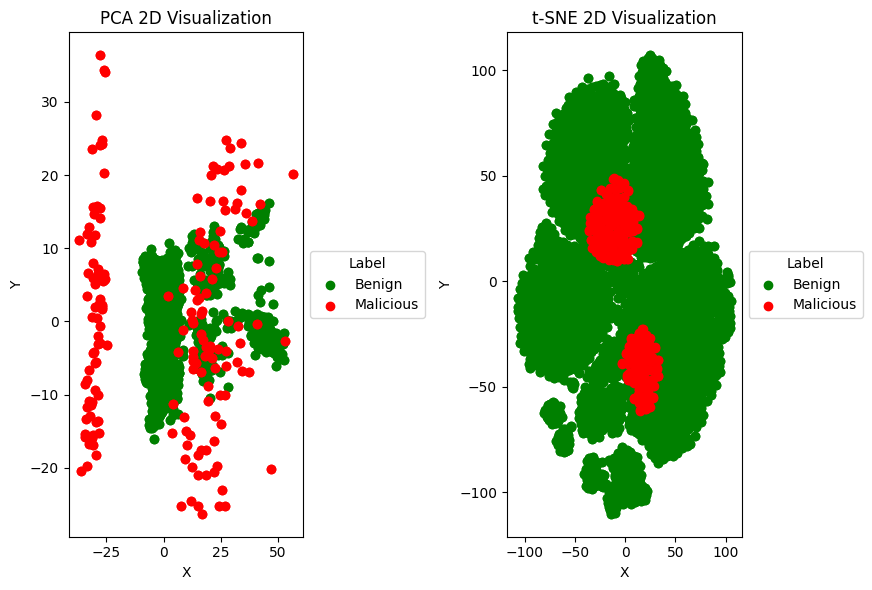

In [141]:
# Perform dimensionality reduction using PCA for 2D visualization
pca = PCA(n_components=2)
reduced_data_2d = {key: pca.fit_transform(value) for key, value in test_encoded_2017_binary.items()}

# Perform dimensionality reduction using t-SNE for 2D visualization
tsne = TSNE(n_components=2)
reduced_data_tsne_2d = {key: tsne.fit_transform(value) for key, value in test_encoded_2017_binary.items()}


# Plot 2D visualizations
plt.figure(figsize=(12, 6))

# Plot PCA 2D visualization
plt.subplot(131)
for key, value in reduced_data_2d.items():
    plt.scatter(value[:, 0], value[:, 1], label=key, color=colors_binary_2017[key])
    
plt.xlabel('X')  # Add x-axis label
plt.ylabel('Y')  # Add y-axis label
plt.title('PCA 2D Visualization')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Label')

# Plot t-SNE 2D visualization
plt.subplot(132)
for key, value in reduced_data_tsne_2d.items():
    plt.scatter(value[:, 0], value[:, 1], label=key, color=colors_binary_2017[key])
    
plt.xlabel('X')  # Add x-axis label
plt.ylabel('Y')  # Add y-axis label
plt.title('t-SNE 2D Visualization')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Label')



plt.tight_layout()
#plt.savefig('output_plot_2018.pdf', dpi=300)
plt.show()

In [142]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [149]:
# Assuming test_encoded_2017 contains your data and labels
X = np.vstack(list(test_encoded_2017.values()))
y = np.hstack([i * np.ones(shape=(len(value),)) for i, value in enumerate(test_encoded_2017.values())])

# Apply LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)


In [158]:
label_mapping = {0: 'Benign', 1: 'DoS GoldenEye', 2: 'Heartbleed', 3: 'DoS Slowhttptest', 4: 'DoS Slowloris'
                , 5: 'DoS Hulk', 6: 'PortScan', 7: 'DDoS', 8: 'Infiltration'
                , 9: 'Web Attack-BruteForce', 10: 'SSH-Patator', 11: 'FTP-Patator'}


In [159]:
original_labels = [label_mapping[label] for label in y]

In [160]:
test_encoded_2017_binary_lda = {
    'LDA': X_lda,  # Store the LDA-reduced data
    'labels': original_labels  # Store the class labels
}

In [228]:
unique_labels = np.unique(y)
color_mapping = color_mapping = {label: np.random.rand(3,) for label in unique_labels}
# color_mapping = color_mapping = {
#     'Benign': 'green',
#     'DoS GoldenEye': 'red' , 'Heartbleed': 'gold' ,
#     'DoS Slowhttptest':'indigo' ,'DoS Slowloris':'plum' ,
#     'DoS Hulk':'violet' ,'PortScan':'khaki' ,'DDoS':'mediumseagreen' ,'Infiltration':'black' ,
#     'Web Attack-BruteForce': 'cyan','SSH-Patator': 'magenta','FTP-Patator':'yellow'}


In [229]:
colors = [color_mapping[label] for label in y]

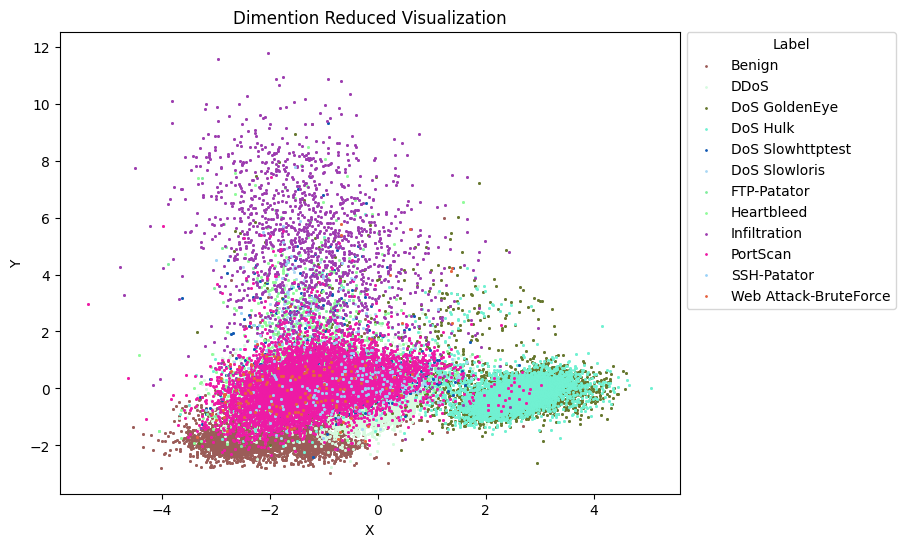

In [234]:
X_lda = test_encoded_2017_binary_lda['LDA']  # Replace 'LDA' with the actual key in your dictionary
y = test_encoded_2017_binary_lda['labels']  # Replace 'labels' with the actual key in your dictionary

# Create a scatter plot for the LDA-reduced data
plt.figure(figsize=(8, 6))

for label in unique_labels:
    class_indices = [index for index, item in enumerate(y) if item ==label]
    class_data = X_lda[class_indices]
    plt.scatter(class_data[:, 0], class_data[:, 1], c=[color_mapping[label]], label=f'{label}', s =1)

# Add labels and a legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Dimention Reduced Visualization')

# Show the legend with all classes
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7), title='Label')
plt.savefig('output_plot_2017_lda.pdf', dpi=300)
plt.show()